##### Load dependencies

In [1]:
from cil.framework import DataContainer #,AcquisitionData
from cil.utilities.display import show_geometry, show2D
from cil.utilities.jupyter import islicer
from cil.io import NikonDataReader, TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, RingRemover
# from cil.processors import , Padder, Slicer, TransmissionAbsorptionConverter
from cil.recon import FDK

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path


##### Load the data

Specify the parent directory and list the scans

In [2]:
# Specify the parent directory
parent_directory = "data"

# Make sure the directory exists
if not os.path.isdir(parent_directory):
    raise IOError(parent_directory + " is not a directory.")
    
# list the scans in the directory
files = glob.glob(os.path.join(parent_directory, '*.xtekct'))

# Make sure the directory contains a single xtekct file
if len(files) == 0:
    raise IOError(parent_directory + " is a directory but it does not contain any xtekct file.")

if len(files) > 1:
    print("WARNING:", parent_directory + " is a directory but it contains several xtekct files. The first one", files[0], "will be used by default.")


for i, file in enumerate(files):
    print(str(i) + ': ' + str(file))

0: data/NXCT0462-AG_SD-card_8gb_Al3.xtekct


choose the number of the file in the files list 

In [3]:
filename = files[0]

or uncomment below to specify the filename directly

In [4]:
# filename = '/mnt/data/path/file.xtekct'

In [5]:
# Instanciate the reader
reader = NikonDataReader(file_name=filename);

# Read the data
data = reader.read()

In [6]:
# Inspect the geometry
print(data.geometry);

3D Cone-beam tomography
System configuration:
	Source position: [  0.     , -70.34352,   0.     ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.     , 901.39248,   0.     ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [3192 2296]
	Pixel size: [0.127 0.127]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-9 in degrees: [14.873001 , 12.872635 , 10.872253 ,  8.871887 ,  6.871521 ,  4.8711395,
  2.8707733,  0.8704071, -1.1299744, -3.1303406]
	Angles 170-179 in degrees: [-325.19006, -327.19043, -329.1908 , -331.19116, -333.19153, -335.1919 ,
 -337.19232, -339.1927 , -341.19305, -343.19342]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


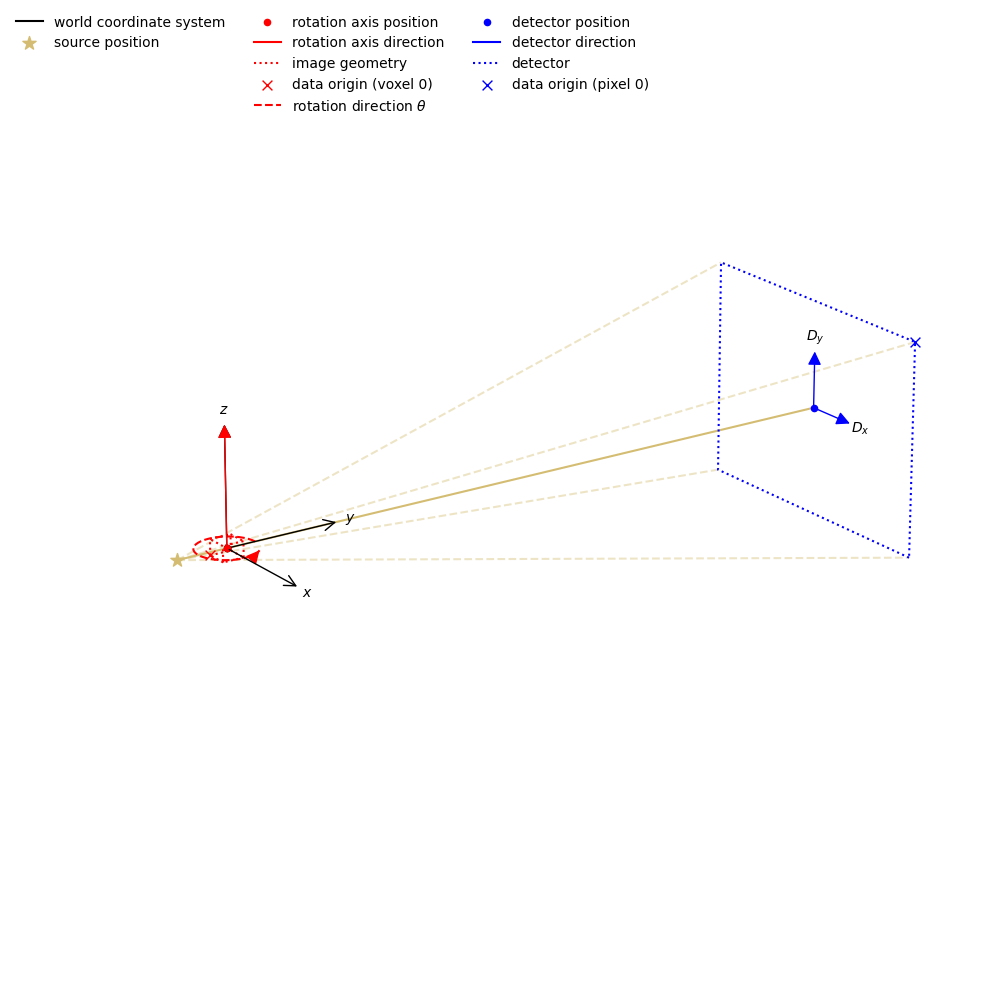

Saved image as /home/fpvidal/PROGRAMMING/GitHub/CCPi-Users-NXCT-Manchester/data/geometry.png


<Figure size 640x480 with 0 Axes>

In [7]:
# Plot and save the geometry
fname = os.path.join(parent_directory, "geometry.png");
show_geometry(data.geometry).save(fname);

In [8]:
# Inspect the projections
islicer(data, direction='angle', origin="upper-left");

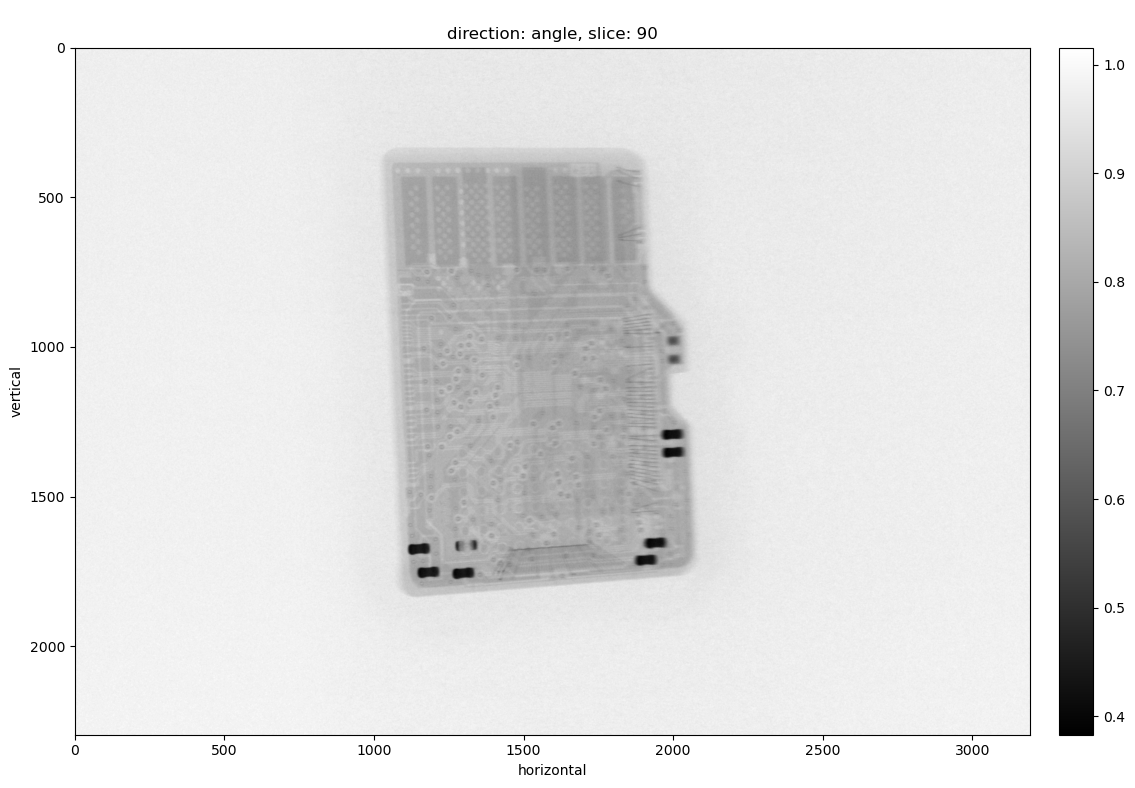

In [9]:
show2D(data, origin="upper-left");

##### Normalise using $-\ln\left(\frac{data}{white\_level}\right)$

##### Transmission to absorption 

Use the CIL `TransmissionAbsorptionConverter`
- If there are negative numbers in the data, specify a low value in `min_intensity` to clip these values before calculating -log

In [10]:
data_corr = TransmissionAbsorptionConverter(min_intensity=0.00001, white_level=data.max())(data);

Plot the sinogram of the centre slice using show2D

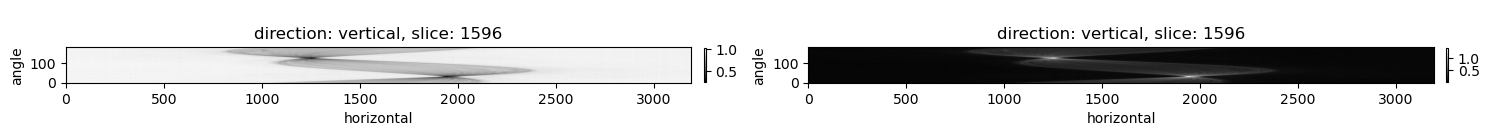

In [11]:
show2D([data, data_corr], slice_list=('vertical', data.shape[2] // 2))

##### Get a vertical slice of the data

##### Filtered back projection

We use the CIL filtered back projection. By default this uses a Ram-Lak

In [17]:
data_slice = data_corr.get_slice(vertical="centre")

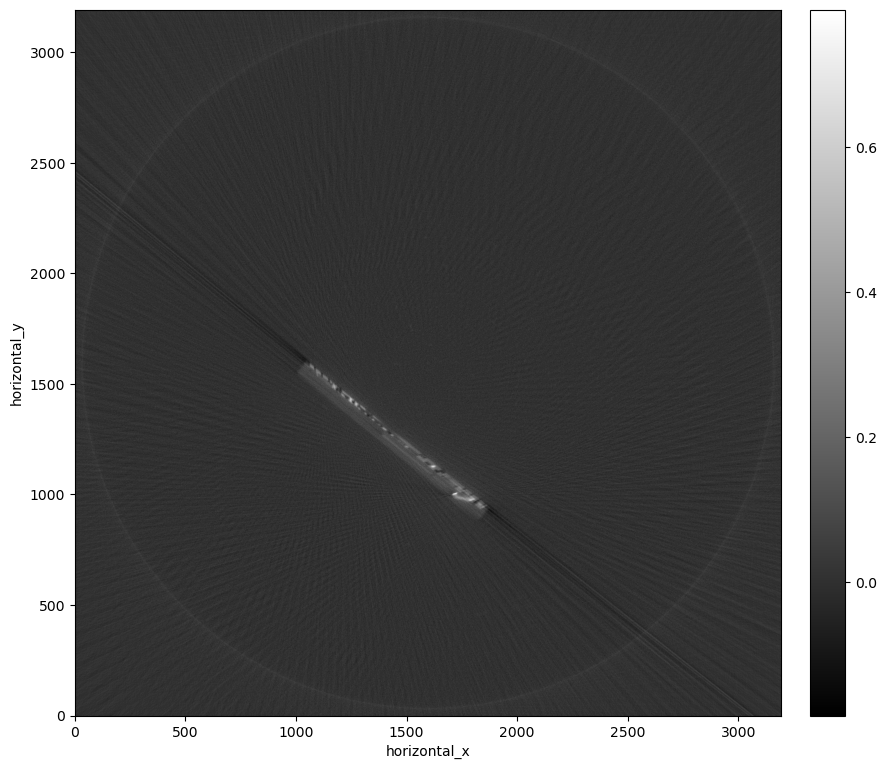

In [19]:
ig = data_slice.geometry.get_ImageGeometry();
reco_before = FDK(data_slice, ig).run(verbose=False)
show2D(reco_before)

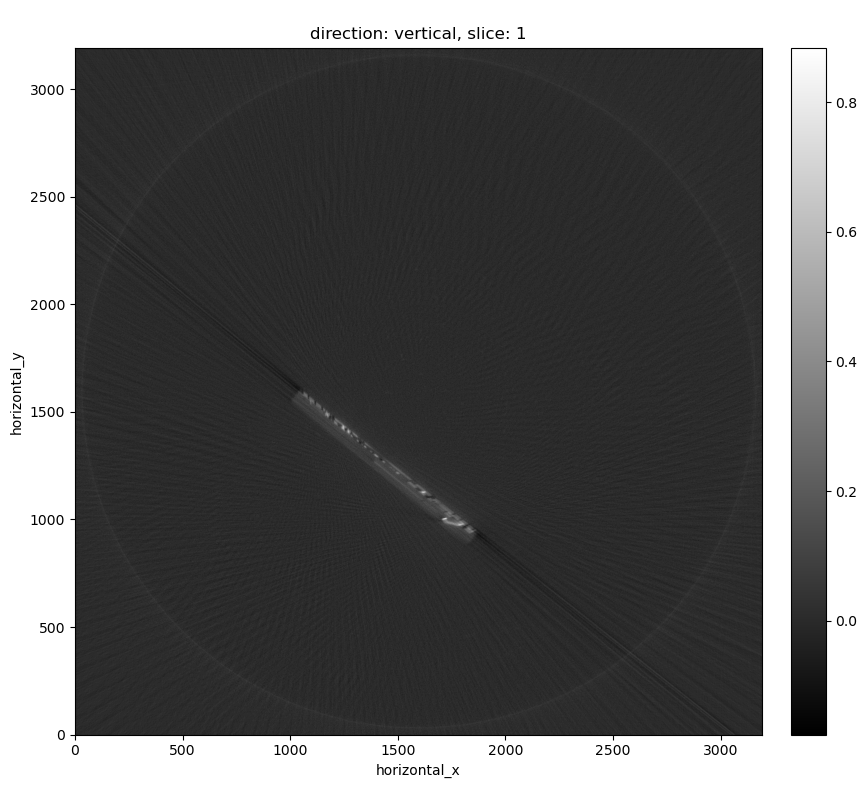

In [12]:
# Define a ROI to reconstruct the 3 middle slices only
ig = data_corr.geometry.get_ImageGeometry();
ig.voxel_num_z = 3

reco_before = FDK(data_corr, ig).run(verbose=False)
show2D(reco_before)

##### Centre of rotation correction

If the data has projections which are 180 degrees apart, uncomment this cell to use the CIL `CentreOfRotationCorrector.xcorrelation` processor to find the centre of rotation offset automatically
- Specify a first projection to use for the correlation, and the algorithm will identify the second angle which is 180 degrees from the first - within a specified angular tolerance 

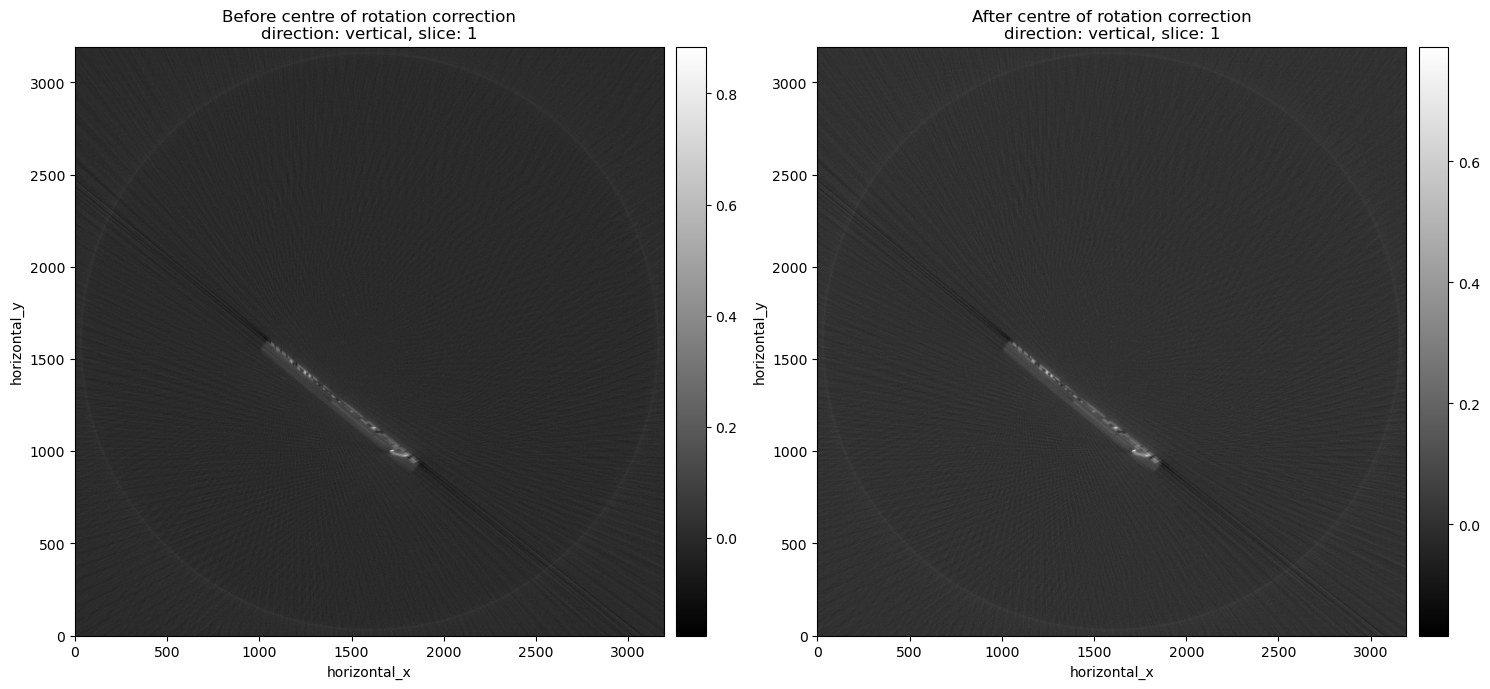

In [14]:
processor = CentreOfRotationCorrector.image_sharpness(slice_index='centre', tolerance=1/125)
processor.set_input(data_corr)
processor.get_output(out=data_corr)

reco = FDK(data_corr, ig).run(verbose=False)
show2D([reco_before, reco],
['Before centre of rotation correction','After centre of rotation correction'])

Print the geometry to see the rotation axis has been changed

In [16]:
print(data_corr.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.     , -70.34352,   0.     ]
	Rotation axis position: [-0.01232887,  0.        ,  0.        ]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.     , 901.39248,   0.     ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [3192 2296]
	Pixel size: [0.127 0.127]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-9 in degrees: [14.873001 , 12.872635 , 10.872253 ,  8.871887 ,  6.871521 ,  4.8711395,
  2.8707733,  0.8704071, -1.1299744, -3.1303406]
	Angles 170-179 in degrees: [-325.19006, -327.19043, -329.1908 , -331.19116, -333.19153, -335.1919 ,
 -337.19232, -339.1927 , -341.19305, -343.19342]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


Alternatively manually enter a pixel offset.

In [ ]:
# pixel_offset = ???
# data_corr.geometry.set_centre_of_rotation(pixel_offset, distance_units='pixels')

##### Crop the data

In [ ]:
# data_before = data_slice.copy()

# processor = Slicer(roi = {'horizontal':(500,2100,1)})
# processor.set_input(data_slice)
# data_slice = processor.get_output()

# show2D([data_before, data_slice], title=['Before cropping', 'After cropping'])


Compare the reconstruction

In [ ]:
# reco = FBP(data_slice).run(verbose=False)
# reco.apply_circular_mask(0.9)

# show2D([reco_before.array[1000:1100,1000:1100], reco.array[1000:1100,1000:1100]])

Plot a cross-section through the reconstruction

In [ ]:
# plt.plot(reco_before.array[1100,1100:1200])
# plt.plot(reco.array[1100,1100:1200])
# plt.xlabel('Horizontal x (pixels)')
# plt.ylabel('Intensity')
# plt.legend(['Before phase retrieval','After phase retrieval'])

##### Ring remover

Use the CIL ring remover processor to remove rings using a wavelet decomposition method

- Increasing sigma increases the frequency of ring artefacts that can be removed
- Increasing the number of decompositions  will increase the strength of the ring remover, but too high sigma will distort the profile of the image

In [ ]:
# data_before = data_slice.copy()
# reco_before = reco.copy()

As above, we can loop through different parameters and view the reconstructions with islicer

In [20]:
array_list = []
array_list.append(reco.array)
decNum_list = [1, 10, 50, 100, 500]
for d in decNum_list:
    processor = RingRemover(decNum = d, wname = "db35", sigma = 1.5,  info = True)
    processor.set_input(data_corr)
    temp_data = processor.get_output()
    reco = FDK(temp_data, ig).run(verbose=False)
    array_list.append(reco.array[1])

Finish Ring Remover
Finish Ring Remover
Finish Ring Remover
Finish Ring Remover
Finish Ring Remover


NameError: name 'np' is not defined

In [24]:
temp = []

for i in range(len(array_list)):
    show2D(array_list[i][1])

In [25]:
DC = DataContainer(np.stack(temp, axis=0), dimension_labels=tuple(['Ring remover decNum']) + reco.geometry.dimension_labels)


ValueError: dimension_labels expected a list containing 3 strings got ('Ring remover decNum', 'vertical', 'horizontal_y', 'horizontal_x')

There's a ring visible at (700-1100, 700-1100). Cycle through the slices to see how well it is removed

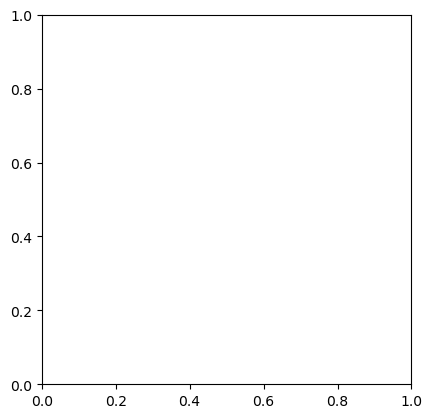

In [23]:
islicer(DC, slice_number=0)


Choose the preferred ring removal method and apply it to the data 

In [ ]:
best_snr = 5
data_slice = rem.remove_all_stripe(data_before.as_array(), best_snr, 5, 1)
data_slice = AcquisitionData(data_slice.astype(np.float32), geometry=data_before.geometry)
reco = FBP(data_slice).run(verbose=False)
show2D([reco_before.array[700:1000,700:1000], reco.array[700:1000,700:1000]])

##### Save the processed data

Once we've happy with the reconstruction save the processed data as TIFF

In [ ]:
writer = TIFFWriter()
writer.set_up(data = data_slice, file_name='path_to_data/data.tiff') #add data type, cast to float16
# writer.write()